In [11]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# Define the specific log files to analyze
LOG_FILES = {
    # Stage 3 - ZeRO-3
    'Stage superoffload': '/users/rasteiger/LSAIE-Project/scripts/logs/deepspeed/stage_superoffload_latest.out',
    'Stage superoffload (Grad Clip)': '/users/rasteiger/LSAIE-Project/scripts/logs/deepspeed/stage_superoffload_grad_clip_latest.out',
}

def parse_log_file(filepath):
    """Parse a DeepSpeed log file and extract training metrics."""
    pattern = re.compile(
        r'Step: (\d+) \| Loss: ([\d.]+) \| Tokens per second: ([\d.]+) \| '
        r'Training tokens per second \(%\): ([\d.]+) \| MFU \(%\): ([\d.]+) \| TFLOPs: ([\d.]+)'
    )
    
    data = []
    try:
        with open(filepath, 'r') as f:
            for line in f:
                match = pattern.search(line)
                if match:
                    step, loss, tps, train_tps_pct, mfu, tflops = match.groups()
                    data.append({
                        'step': int(step),
                        'loss': float(loss),
                        'tokens_per_second': float(tps),
                        'training_tokens_pct': float(train_tps_pct),
                        'mfu_pct': float(mfu),
                        'tflops': float(tflops)
                    })
    except FileNotFoundError:
        print(f"Warning: File not found - {filepath}")
        return pd.DataFrame()
    
    return pd.DataFrame(data)

# Parse all log files
all_data = {}
for name, filepath in LOG_FILES.items():
    df = parse_log_file(filepath)
    if not df.empty:
        # Average across ranks (multiple entries per step)
        df_avg = df.groupby('step').mean().reset_index()
        all_data[name] = df_avg
        print(f"✓ Loaded {name}: {len(df_avg)} steps")
    else:
        print(f"✗ Failed to load {name}")

print(f"\nSuccessfully loaded {len(all_data)} experiments")

✓ Loaded Stage superoffload: 51 steps
✓ Loaded Stage superoffload (Grad Clip): 51 steps

Successfully loaded 2 experiments


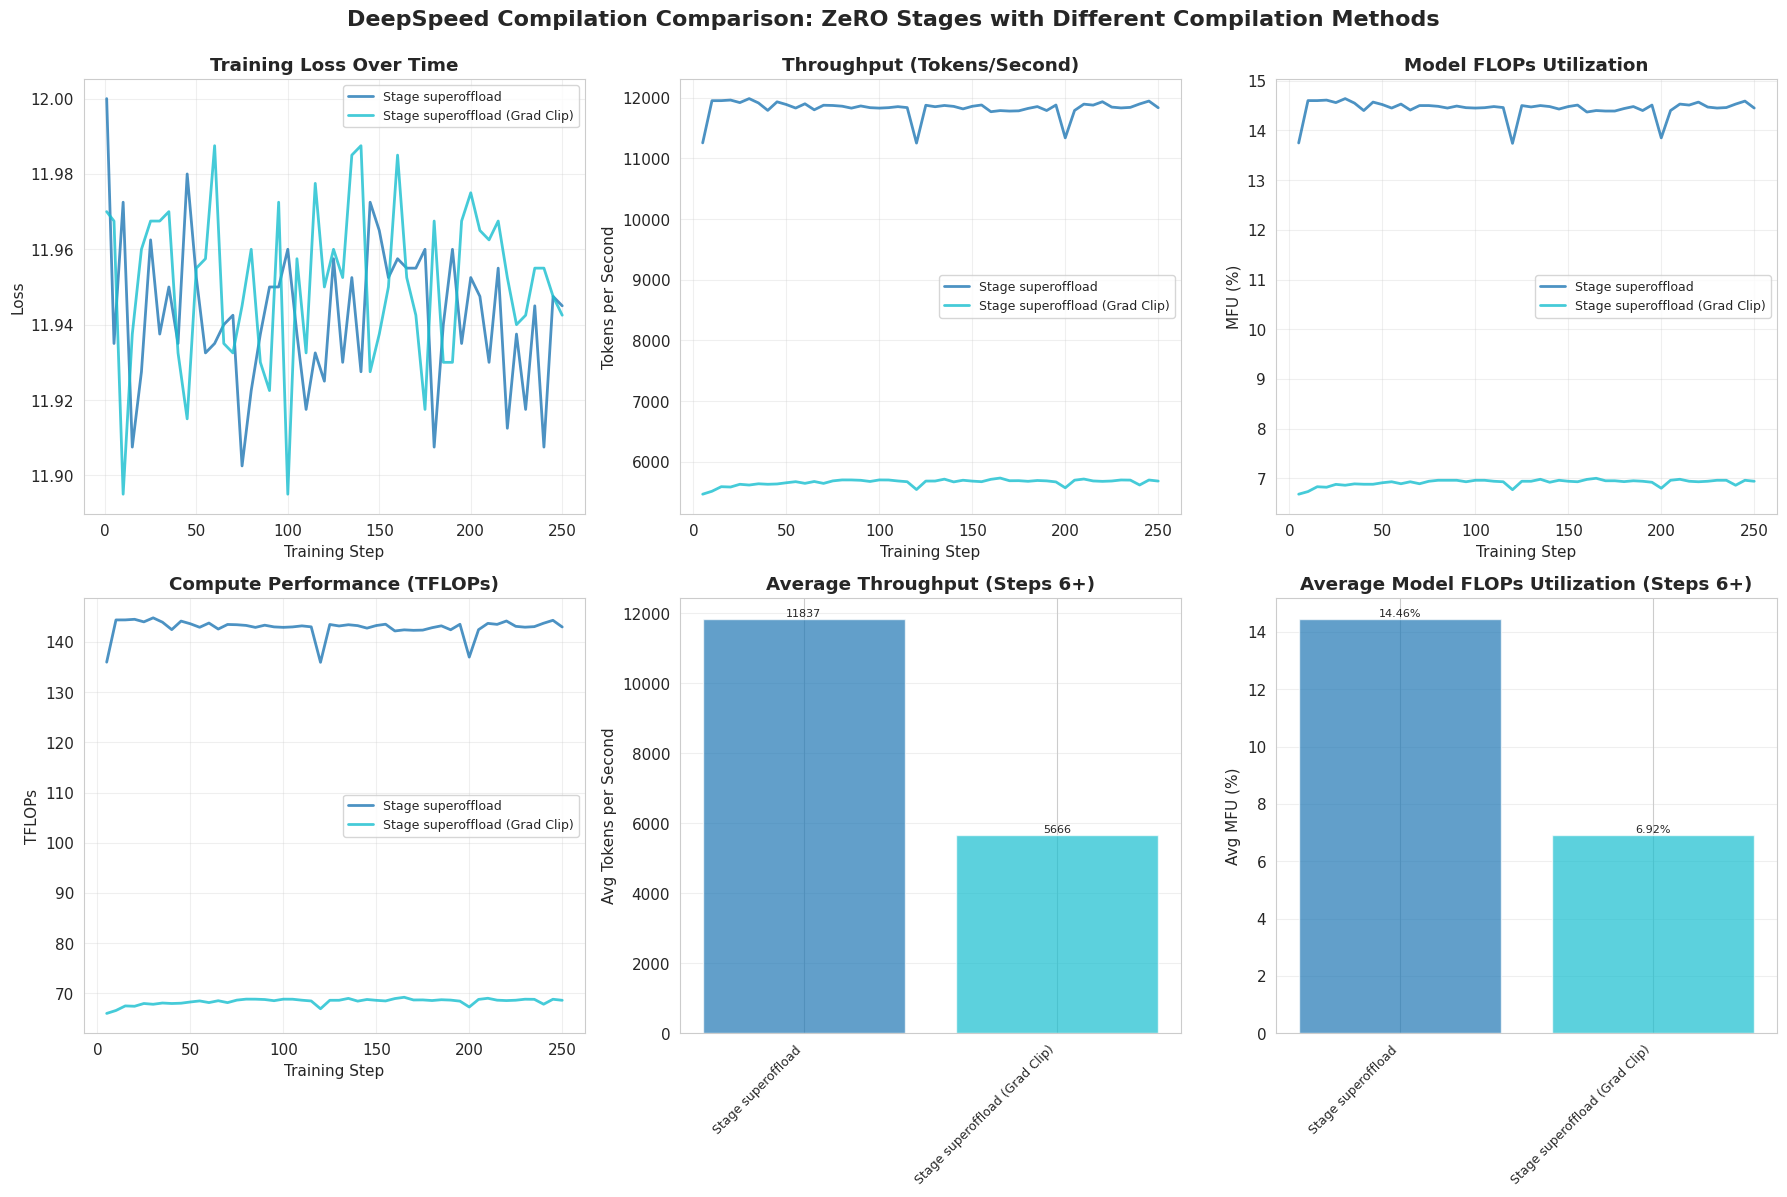

In [12]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('DeepSpeed Compilation Comparison: ZeRO Stages with Different Compilation Methods', 
             fontsize=16, fontweight='bold', y=0.995)

# Define color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(all_data)))
color_map = dict(zip(all_data.keys(), colors))

# 1. Training Loss
ax = axes[0, 0]
for name, df in all_data.items():
    ax.plot(df['step'], df['loss'], label=name, linewidth=2, alpha=0.8, color=color_map[name])
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Over Time', fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Tokens per Second (Throughput)
ax = axes[0, 1]
for name, df in all_data.items():
    # Exclude first step (warmup) for better visualization
    df_plot = df[df['step'] > 1]
    ax.plot(df_plot['step'], df_plot['tokens_per_second'], label=name, 
            linewidth=2, alpha=0.8, color=color_map[name])
ax.set_xlabel('Training Step')
ax.set_ylabel('Tokens per Second')
ax.set_title('Throughput (Tokens/Second)', fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# 3. Model FLOPs Utilization (MFU)
ax = axes[0, 2]
for name, df in all_data.items():
    df_plot = df[df['step'] > 1]
    ax.plot(df_plot['step'], df_plot['mfu_pct'], label=name, 
            linewidth=2, alpha=0.8, color=color_map[name])
ax.set_xlabel('Training Step')
ax.set_ylabel('MFU (%)')
ax.set_title('Model FLOPs Utilization', fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# 4. TFLOPs
ax = axes[1, 0]
for name, df in all_data.items():
    df_plot = df[df['step'] > 1]
    ax.plot(df_plot['step'], df_plot['tflops'], label=name, 
            linewidth=2, alpha=0.8, color=color_map[name])
ax.set_xlabel('Training Step')
ax.set_ylabel('TFLOPs')
ax.set_title('Compute Performance (TFLOPs)', fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# 5. Average Throughput Comparison (Bar Chart)
ax = axes[1, 1]
avg_throughput = {}
for name, df in all_data.items():
    # Average excluding first 5 warmup steps
    df_steady = df[df['step'] > 5]
    if len(df_steady) > 0:
        avg_throughput[name] = df_steady['tokens_per_second'].mean()

names = list(avg_throughput.keys())
values = list(avg_throughput.values())
bars = ax.bar(range(len(names)), values, color=[color_map[n] for n in names], alpha=0.7)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Avg Tokens per Second')
ax.set_title('Average Throughput (Steps 6+)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.0f}', 
            ha='center', va='bottom', fontsize=8)

# 6. Average MFU Comparison (Bar Chart)
ax = axes[1, 2]
avg_mfu = {}
for name, df in all_data.items():
    df_steady = df[df['step'] > 5]
    if len(df_steady) > 0:
        avg_mfu[name] = df_steady['mfu_pct'].mean()

names = list(avg_mfu.keys())
values = list(avg_mfu.values())
bars = ax.bar(range(len(names)), values, color=[color_map[n] for n in names], alpha=0.7)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Avg MFU (%)')
ax.set_title('Average Model FLOPs Utilization (Steps 6+)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.2f}%', 
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [13]:
# Create summary statistics table
print("\n" + "="*100)
print("SUMMARY STATISTICS (Averaged over steps 6+)")
print("="*100)

summary_data = []
for name, df in all_data.items():
    df_steady = df[df['step'] > 5]
    if len(df_steady) > 0:
        summary_data.append({
            'Configuration': name,
            'Avg Throughput (tok/s)': f"{df_steady['tokens_per_second'].mean():.2f}",
            'Avg MFU (%)': f"{df_steady['mfu_pct'].mean():.2f}",
            'Avg TFLOPs': f"{df_steady['tflops'].mean():.2f}",
            'Final Loss': f"{df_steady['loss'].iloc[-1]:.2f}",
            'Total Steps': len(df)
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*100)

# Calculate speedup relative to baseline (no compile) for each stage
print("\n" + "="*100)
print("SPEEDUP ANALYSIS (Relative to No Compile baseline)")
print("="*100)

for stage in [1, 2, 3]:
    baseline_key = f'Stage {stage} (No Compile)'
    if baseline_key in all_data:
        baseline_df = all_data[baseline_key]
        baseline_throughput = baseline_df[baseline_df['step'] > 5]['tokens_per_second'].mean()
        
        print(f"\n--- Stage {stage} (ZeRO-{stage if stage > 1 else 'disabled'}) ---")
        for compile_method in ['torch.compile', 'DeepCompile']:
            method_key = f'Stage {stage} ({compile_method})'
            if method_key in all_data:
                method_df = all_data[method_key]
                method_throughput = method_df[method_df['step'] > 5]['tokens_per_second'].mean()
                speedup = (method_throughput / baseline_throughput - 1) * 100
                print(f"  {compile_method:15s}: {method_throughput:8.2f} tok/s ({speedup:+.2f}% vs baseline)")

print("="*100)


SUMMARY STATISTICS (Averaged over steps 6+)
                 Configuration Avg Throughput (tok/s) Avg MFU (%) Avg TFLOPs Final Loss  Total Steps
            Stage superoffload               11837.01       14.46     142.99      11.95           51
Stage superoffload (Grad Clip)                5665.85        6.92      68.44      11.94           51

SPEEDUP ANALYSIS (Relative to No Compile baseline)
